**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [1]:
import sys
sys.path.append('gan-uncertainty-ensembles')

In [2]:
from deep_ensembles import nets, data
from deep_ensembles.params import *
from deep_ensembles.train import train, repeater, ParticleSet
#from deep_ensembles.eval import count_model_accuracy, count_uncertainty, eval_model_by_classifier, eval_model_by_ks

In [3]:
data_dir = 'rich'
import os
import numpy as np

def get_particle_dset(particle):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir) if particle in name]

datasets = {particle: get_particle_dset(particle) for particle in PARTICLES} 


In [4]:
data_train, data_val, _, data_train_s, data_val_s, data_test_s, scaler = data.get_val_dataset(datasets, PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	rich/pion_-_up_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion2_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.903419017791748
scaling train set
scaling val set
scaling val set
converting dtype to <class 'numpy.float32'>


In [5]:
def split_by_bands(feats, targets, band_size=105000):
    distances = np.abs(feats[:, 0] - feats[:, 1])
    sort_indices = np.argsort(distances)

    feats_sorted = feats[sort_indices]
    targets_sorted = targets[sort_indices]

    num_bands = (feats.shape[0] - 1) // band_size + 1

    bands = []
    for i in range(num_bands):
        start = i * band_size
        end = start + band_size

        band = (feats_sorted[start:end], targets_sorted[start:end])
        bands.append(band)

    return bands

In [6]:
def split_by_line(df, slope=1, intercept=0):
    top_half = df[df['Brunel_ETA'] > df['Brunel_P'] * slope + intercept]
    bottom_half = df[df['Brunel_ETA'] <= df['Brunel_P'] * slope + intercept]

    top_half = top_half.reset_index(drop=True)
    bottom_half = bottom_half.reset_index(drop=True)

    return top_half, bottom_half

In [7]:
l_val, r_val = split_by_line(data_val_s)

In [8]:
l_train, r_train = split_by_line(data_train_s)

In [9]:
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.displot(l_val, x='Brunel_P', y='Brunel_ETA', cbar=True)
#plt.show()

In [10]:
def parse_dataset_np(data, r):
    targets = data.iloc[:, :5].to_numpy()
    features = data.iloc[:, -4:-1].to_numpy()
    weight = data.iloc[:, -1].to_numpy()

    return features[r], targets[r], weight[r]



In [11]:
r = np.random.choice(list(range(r_train.shape[0])), size=50000)
l = np.random.choice(list(range(l_train.shape[0])), size=50000)
r_feats_val, r_targets_val, _ = parse_dataset_np(r_train, r)
r_bands = split_by_bands(r_feats_val, r_targets_val, 10000)
l_feats_val, l_targets_val, _ = parse_dataset_np(l_train, l)
l_bands = split_by_bands(l_feats_val, l_targets_val, 10000)


In [12]:
bands = l_bands[::-1] + r_bands[:]

In [13]:
len(bands)

10

(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)


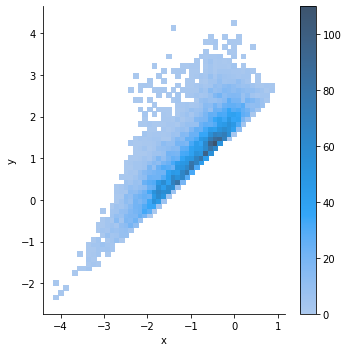

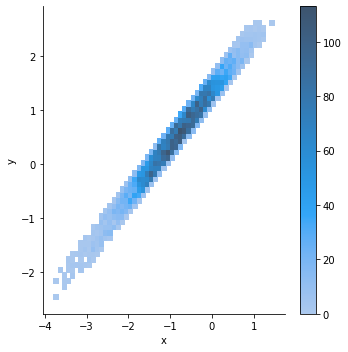

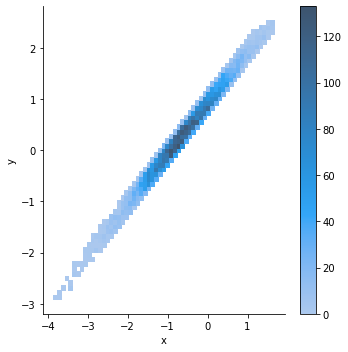

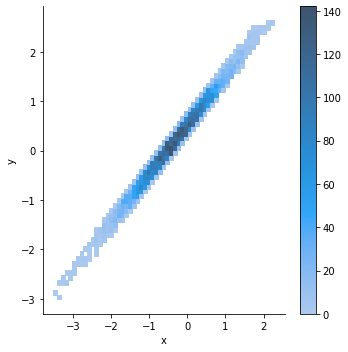

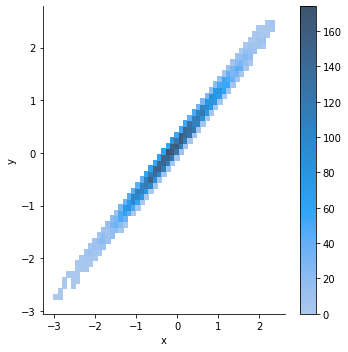

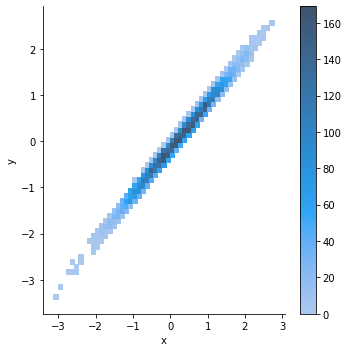

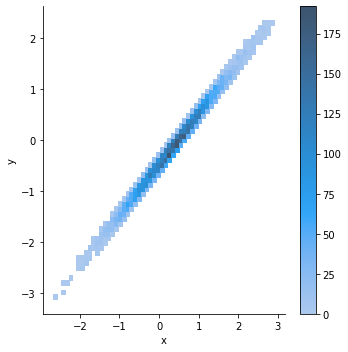

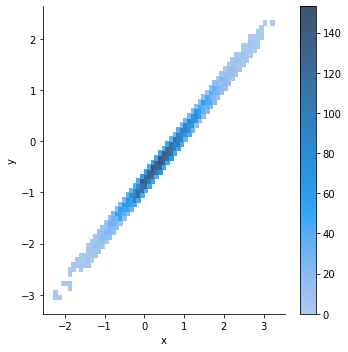

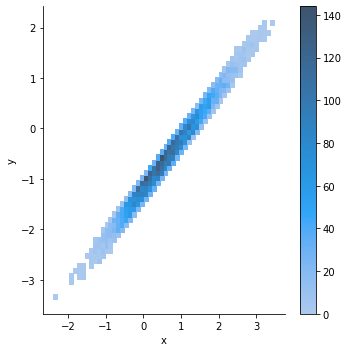

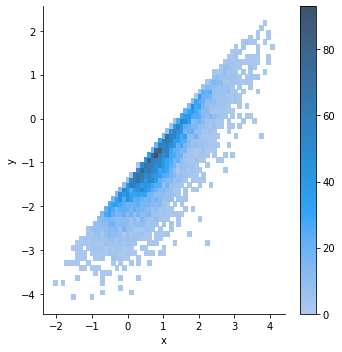

In [14]:
import pandas as pd
#import seaborn as sns
for band in bands:
    feats, _ = band
    print(feats.shape)
    hist_df = pd.DataFrame(feats[:,:2], columns=['x', 'y'])
#    sns.displot(hist_df, x='x', y='y', cbar=True)
plt.show()

In [17]:
feats[:,:2].shape

(10000, 2)

In [15]:
import pandas as pd
#import seaborn as sns
hist_dfs = [None] * len(bands)
for i, band in enumerate(bands):
    feats, ts = band
    d = np.concatenate([ts, feats], axis=1)
    d = scaler.inverse_transform(d)[:,5:7]
    d[:, 0] /= 1000
    hist_df = pd.DataFrame(d, columns=['Momentum (GeV/c)', 'Pseudorapidity'])
    hist_df['labels'] = 'train data' if i < 5 else f'test band #{i}'
    hist_dfs[i] = hist_df

In [16]:
result = pd.concat(hist_dfs)
plt.subplots_adjust(hspace = .3)


<Figure size 432x288 with 0 Axes>

In [17]:
clrs1 = list(sns.color_palette("bright", 10))

In [18]:
new_clrs = [clrs1[7], clrs1[4],clrs1[8], clrs1[2], clrs1[8],  clrs1[0]]

In [259]:
d = result

In [219]:

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
newcmps = []
for c in colors:
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(max(0, c[0]-0.1),min(c[0]+0.1, 1), N)
    vals[:, 1] = np.linspace(max(0, c[1]-0.1),min(c[1]+0.1, 1), N)
    vals[:, 2] = np.linspace(max(0, c[2]-0.1),min(c[2]+0.1, 1), N)
    newcmp = ListedColormap(vals)
    newcmps.append(newcmp)

In [198]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

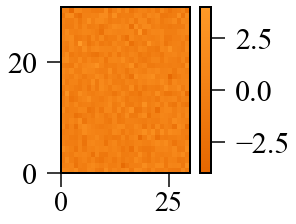

In [209]:
plot_examples([newcmp])


In [213]:
d

Momentum (GeV/c)  Pseudorapidity        labels
0             8.211270         4.20233    train data
1             4.264400         3.79700    train data
2             7.442480         4.14567    train data
3            10.855599         4.37744    train data
4             9.565320         4.29283    train data
...                ...             ...           ...
9995        463.364990         3.11203  test band #9
9996         57.267300         1.92215  test band #9
9997        118.804001         2.10596  test band #9
9998         88.763603         1.98860  test band #9
9999        136.367020         1.91209  test band #9

[100000 rows x 3 columns]

No handles with labels found to put in legend.


<Figure size 800x800 with 0 Axes>

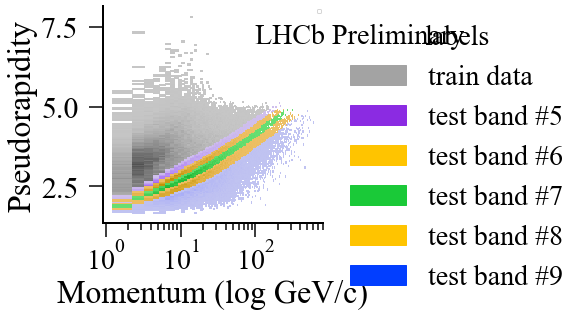

In [214]:
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)


from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator, LogLocator


figure(figsize=(8, 8), dpi=100)
palette = new_clrs
#sns.set(font_scale=1.6)
#sns.set_style("ticks")

sns.displot(d, x='Momentum (GeV/c)', y='Pseudorapidity', hue="labels", palette=palette[:6], )

#plt.plot([-2.7, 2.7], [-2.7, 2.7], linewidth=2.0, color='red', linestyle='--', label='train/test split')
plt.legend(fancybox=True, loc='upper right', fontsize=5
          )
#sns.set(font_scale=22)  
#plt.rc('font', **font)
#plt.savefig('line_test.png')
plt.text(100, 7, "LHCb Preliminary", horizontalalignment='left', color='black')
plt.xscale('log')
plt.xlabel('Momentum (log GeV/c)')
plt.savefig('log extrapolation_test.png', dpi=600)

plt.show()


No handles with labels found to put in legend.


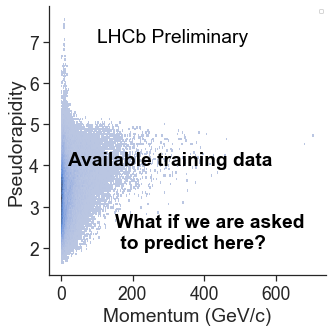

In [25]:
#sns.set(rc={'figure.figsize':(30,30)})

#sns.set_theme(style="whitegrid")
#sns.set_context("poster")
sns.reset_orig()

#sns.set_context("poster", font_scale = 0.7)
palette = new_clrs
sns.set(font_scale=1.6)
sns.set_style("ticks")

sns.displot(d, x='Momentum (GeV/c)', y='Pseudorapidity',  palette=palette[:6], )

#plt.plot([-2.7, 2.7], [-2.7, 2.7], linewidth=2.0, color='red', linestyle='--', label='train/test split')
plt.legend(fancybox=True, loc='upper right', fontsize=5
          )
font = {'family' : 'normal',
        'size'   : 22}
#sns.set(font_scale=22)  
#plt.rc('font', **font)
#plt.savefig('line_test.png')
plt.text(100, 7, "LHCb Preliminary", horizontalalignment='left', color='black')
plt.text(20, 4, "Available training data", horizontalalignment='left', color='black', weight='semibold')
plt.text(150, 2, "What if we are asked\n to predict here?", horizontalalignment='left',  color='black', weight='bold')
plt.tight_layout()
plt.savefig('introduction.png', format='png', dpi=600, bbox_inches='tight', pad_inches=1)

plt.show()


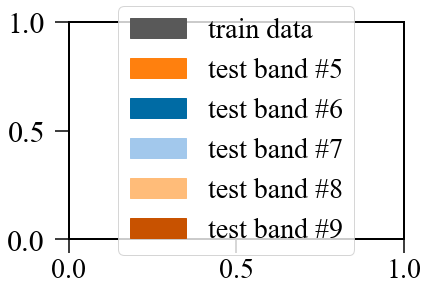

In [225]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
labels = ['train data', 'test band #5', 'test band #6', 'test band #7', 'test band #8', 'test band #9']
legend_elements = [
                   Patch(facecolor=colors[i], edgecolor=colors[i],
                         label=labels[i]) for i in range(6)]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

plt.show()

/Users/laneesra/.pyenv/versions/scikit/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


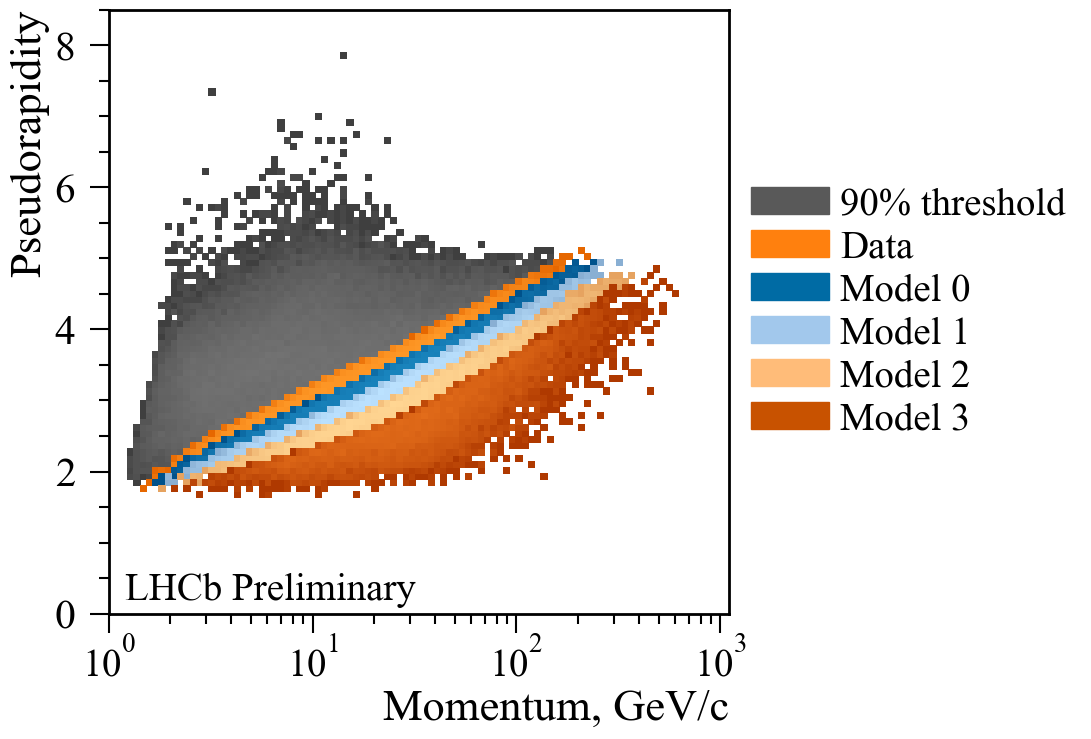

In [261]:

figure(figsize=(8, 8), dpi=100)
from matplotlib import colors as clrs
#sns.set_context("poster", font_scale = 0.7)
#palette = new_clrs
#sns.set(font_scale=1.6)
#sns.set_style("ticks")
bins_x = np.logspace(np.log10(1),np.log10(1100), 100)
bins_y = np.linspace(0, 8.5, num=100)
for i, label in enumerate(['train data', 'test band #5', 'test band #6', 'test band #7', 'test band #8', 'test band #9']):
    d_plot = d[d['labels']==label]
    plt.hist2d(d_plot['Momentum (GeV/c)'], d_plot['Pseudorapidity'], norm=clrs.LogNorm(), bins=[bins_x, bins_y], cmap=newcmps[i])
    

#plt.plot([-2.7, 2.7], [-2.7, 2.7], linewidth=2.0, color='red', linestyle='--', label='train/test split')

plt.style.use('tableau-colorblind10')

#sns.set(font_scale=22)  
#plt.rc('font', **font)
#plt.savefig('line_test.png')

plt.text(1.2, 0.2, "LHCb Preliminary", horizontalalignment='left', color='black')
#plt.text(550, 5.5, "What if we are \nasked to predict \nhere?", horizontalalignment='right', color='black')
#plt.text(2.5, 2.8, "Available training\ndata", horizontalalignment='left', color='black')
plt.gca().set_xscale('log')
#plt.xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ml = LogLocator(10)

#plt.axes().xaxis.set_minor_locator(ml)
#plt.xticks([1e0, 1e1, 1e2, 1e3])

plt.xlabel('Momentum, GeV/c', ha='right', x=1)
plt.ylabel('Pseudorapidity', ha='right', y=1)
plt.minorticks_on()
legend_elements = [
                   Patch(facecolor=colors[i], edgecolor=colors[i],
                         label=labels[i]) for i in range(6)]
plt.legend(handles=legend_elements, loc='right', ncol=1, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(1.6, 0.5))

plt.savefig('log extrapolation illustration.png', format='png', bbox=True, bbox_inches='tight', pad_inches=0.1)

plt.show()


In [37]:
import pickle

with open("TEST_DATA_DLL.pkl", "rb") as tf:
    TEST_DATA = pickle.load(tf)

In [38]:

with open("TRAIN_DATA_DLL_.pkl", "rb") as tf:
    TRAIN_DATA = pickle.load(tf)

In [39]:
with open("line_test.pkl", "rb") as tf:
    line_test = pickle.load(tf)
    
with open("random.pkl", "rb") as tf:
    random_test = pickle.load(tf)

In [41]:
import pickle
with open('momentum.pickle', 'rb') as fp:
    momentum = pickle.load(fp)


In [42]:
import pickle
with open('data_val.pickle', 'rb') as fp:
    data_val = pickle.load(fp)


In [43]:
import pickle
with open('bands.pickle', 'rb') as fp:
    bs = pickle.load(fp)


In [44]:
import pickle
with open('thresholds.pickle', 'rb') as fp:
    thresholds = pickle.load(fp)


In [45]:
band_features = [bs['band_features'][i] for i in range(bs['band_features'].shape[0])]
band_targets = [bs['band_targets'][i] for i in range(bs['band_targets'].shape[0])]
t_bands = zip(band_features, band_targets)

In [100]:
ax.hist(TRAIN_DATA[f'dlls_n[:, {INDEX}]'],
                      bins=100,
                      label="Data", fill=False, edgecolor='firebrick', histtype='step', linewidth=2)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00,
        4.0000e+00, 7.0000e+00, 4.0000e+00, 7.0000e+00, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 1.0000e+01, 1.7000e+01, 1.7000e+01,
        2.2000e+01, 2.5000e+01, 2.0000e+01, 3.6000e+01, 3.7000e+01,
        5.0000e+01, 4.4000e+01, 6.4000e+01, 7.3000e+01, 8.4000e+01,
        8.3000e+01, 1.1900e+02, 1.2700e+02, 1.8200e+02, 1.9100e+02,
        2.2900e+02, 2.2800e+02, 2.8700e+02, 3.8800e+02, 4.2300e+02,
        5.0900e+02, 6.3900e+02, 7.1100e+02, 8.2600e+02, 9.7800e+02,
        1.1390e+03, 1.3120e+03, 1.5450e+03, 1.6990e+03, 2.0780e+03,
        2.4780e+03, 2.7590e+03, 3.3860e+03, 3.9050e+03, 4.6410e+03,
        5.5050e+03, 6.4020e+03, 7.6060e+03, 9.5510e+03, 1.3517e+04,
        1.8762e+04, 5.1410e+03, 2.6370e+03, 1.51

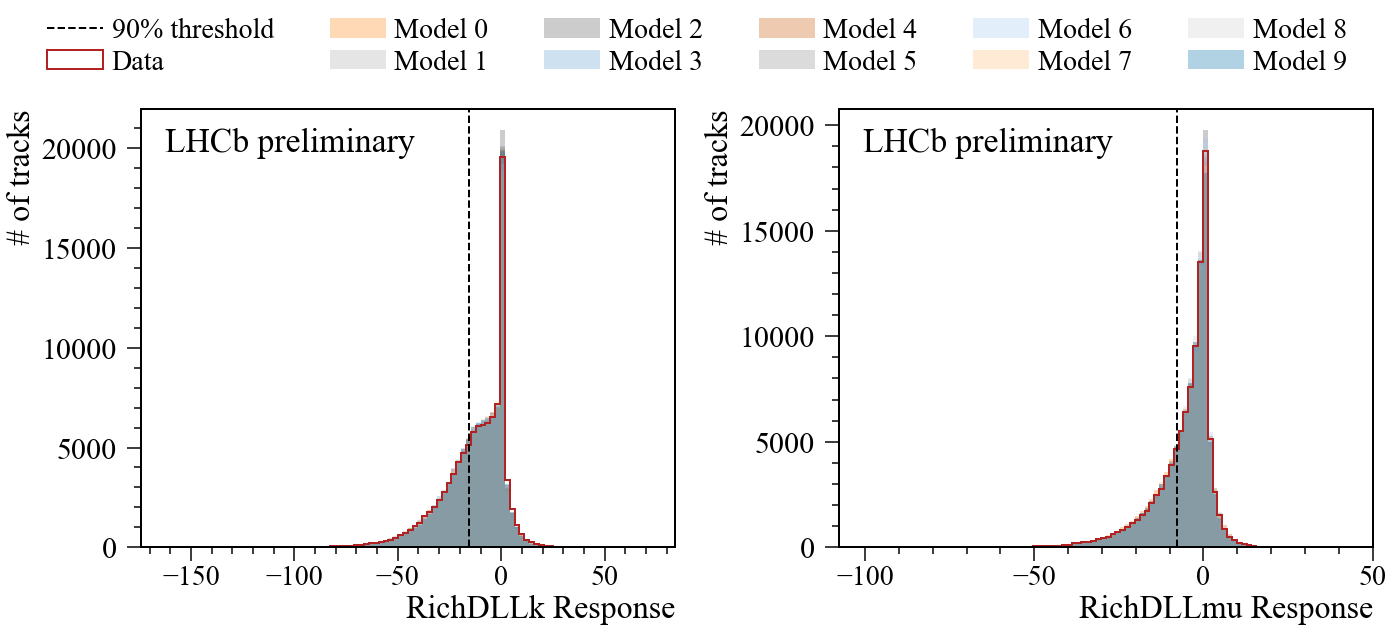

In [264]:
#plt.subplots_adjust(hspace = .3)
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.minorticks_on()
plt.tight_layout()
bins = np.linspace(-100, 50, 500)
plt.gca().ticklabel_format(axis='y', style='sci')
for INDEX, ax in zip((1, 2), axes.flatten()[:5]):
    h1, bins, _ = ax.hist(TRAIN_DATA[f'dlls_n[:, {INDEX}]'],
                      bins=100,
                      label="Data", fill=False, edgecolor='firebrick', histtype='step', linewidth=2)
    x_text = h1.max()
    for i, p in enumerate(range(10)):
        h1, _, _ = ax.hist(TRAIN_DATA[f'preds_n[:, {INDEX}][{i}]'],
                bins=bins,
                label=f"Model {i}",
                alpha=0.3)
        x_text = max(x_text, h1.max())
    _, bins, _ = ax.hist(TRAIN_DATA[f'dlls_n[:, {INDEX}]'],
                  bins=bins,
                  fill=False, edgecolor='firebrick', histtype='step', linewidth=2)

    ax.axvline(TRAIN_DATA[f'thrs[{INDEX}]'], color='k', linestyle='dashed', linewidth=2, label='90% threshold')
    ax.set_xlabel(f'{dll_columns[INDEX]} Response', ha='right', x=1)
    ax.set_ylabel('# of tracks', ha='right', y=1)

    #ax.set_title(dll_columns[INDEX])
    ax.text(bins[0], x_text*0.95, "LHCb preliminary", horizontalalignment='left', size='large', color='black')
    ax.minorticks_on()

handles, labels = ax.get_legend_handles_labels()
plt.minorticks_on()
plt.tight_layout()
plt.gca().ticklabel_format(axis='y', style='sci')
# Create a legend for the first line.
#first_legend = fig.legend(handles[2:], labels[2:], loc='center right', fancybox=True, shadow=True, ncol=1, borderaxespad=0, bbox_to_anchor=(1.15, 0.5))

# Add the legend manually to the Axes.
#fig.add_artist(first_legend)

# Create another legend for the second line.
#fig.legend(handles=[line2], loc='lower right')
#fig.legend(handles[:2], labels[:2], loc='upper center', fancybox=True, shadow=True, ncol=2, borderaxespad=0)
fig.legend(handles, labels, loc='upper center', ncol=6, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(0.5, 1.15))



#legend.frameon:       false
#legend.handletextpad: 0.3
#legend.numpoints:     1
#legend.labelspacing:  0.2
#legend.fontsize:      28
plt.savefig('train set dlls.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()


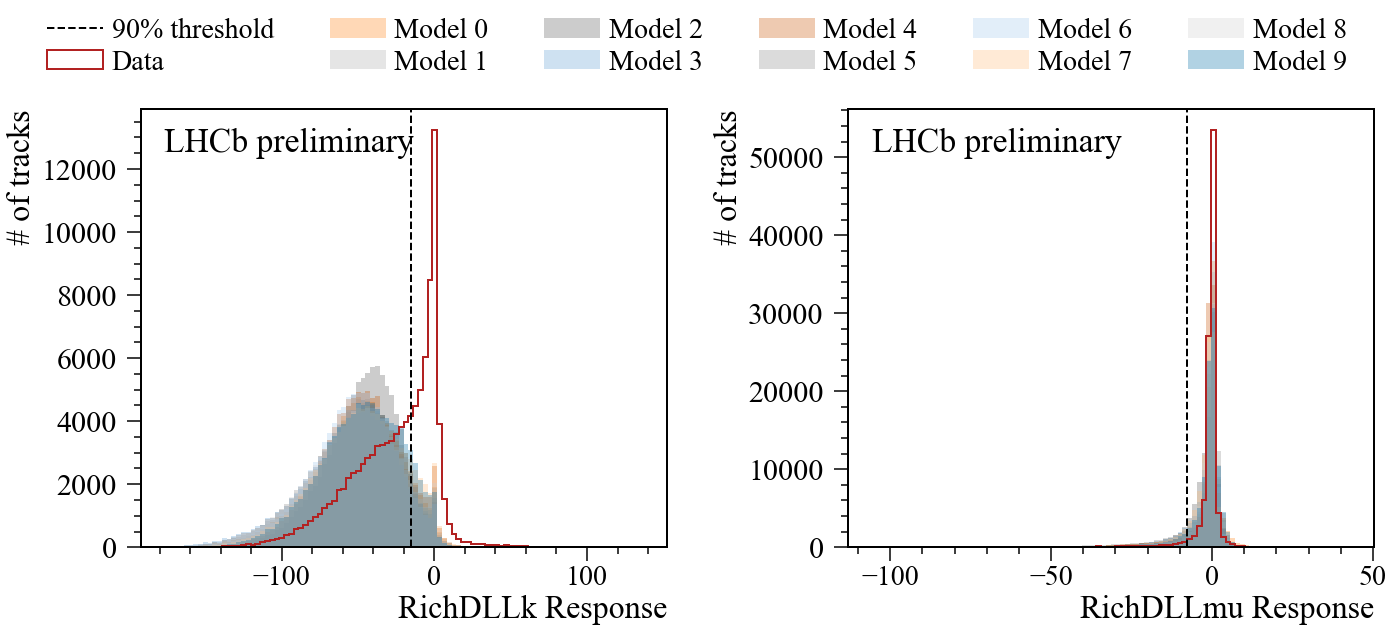

In [285]:
#plt.subplots_adjust(hspace = .3)
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.minorticks_on()
plt.tight_layout()
bins = np.linspace(-100, 50, 500)
plt.gca().ticklabel_format(axis='y', style='sci')
for INDEX, ax in zip((1, 2), axes.flatten()[:5]):
    h1, bins, _ = ax.hist(TEST_DATA[f'dlls_n[:, {INDEX}]'],
                      bins=100,
                      label="Data", fill=False, edgecolor='firebrick', histtype='step', linewidth=2)
    x_text = h1.max()
    for i, p in enumerate(range(10)):
        h1, _, _ = ax.hist(TEST_DATA[f'preds_n[:, {INDEX}][{i}'],
                bins=bins,
                label=f"Model {i}",
                alpha=0.3)
        x_text = max(x_text, h1.max())
    _, bins, _ = ax.hist(TEST_DATA[f'dlls_n[:, {INDEX}]'],
                  bins=bins,
                  fill=False, edgecolor='firebrick', histtype='step', linewidth=2)

    ax.axvline(TRAIN_DATA[f'thrs[{INDEX}]'], color='k', linestyle='dashed', linewidth=2, label='90% threshold')
    ax.set_xlabel(f'{dll_columns[INDEX]} Response', ha='right', x=1)
    ax.set_ylabel('# of tracks', ha='right', y=1)

    #ax.set_title(dll_columns[INDEX])
    ax.text(bins[0], x_text*0.95, "LHCb preliminary", horizontalalignment='left', size='large', color='black')
    ax.minorticks_on()

handles, labels = ax.get_legend_handles_labels()
plt.minorticks_on()
plt.tight_layout()
plt.gca().ticklabel_format(axis='y', style='sci')
# Create a legend for the first line.
#first_legend = fig.legend(handles[2:], labels[2:], loc='center right', fancybox=True, shadow=True, ncol=1, borderaxespad=0, bbox_to_anchor=(1.15, 0.5))

# Add the legend manually to the Axes.
#fig.add_artist(first_legend)

# Create another legend for the second line.
#fig.legend(handles=[line2], loc='lower right')
#fig.legend(handles[:2], labels[:2], loc='upper center', fancybox=True, shadow=True, ncol=2, borderaxespad=0)
fig.legend(handles, labels, loc='upper center', ncol=6, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(0.5, 1.15))



#legend.frameon:       false
#legend.handletextpad: 0.3
#legend.numpoints:     1
#legend.labelspacing:  0.2
#legend.fontsize:      28
plt.savefig('test set dlls.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()


/Users/laneesra/.pyenv/versions/scikit/lib/python3.6/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Users/laneesra/.pyenv/versions/scikit/lib/python3.6/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


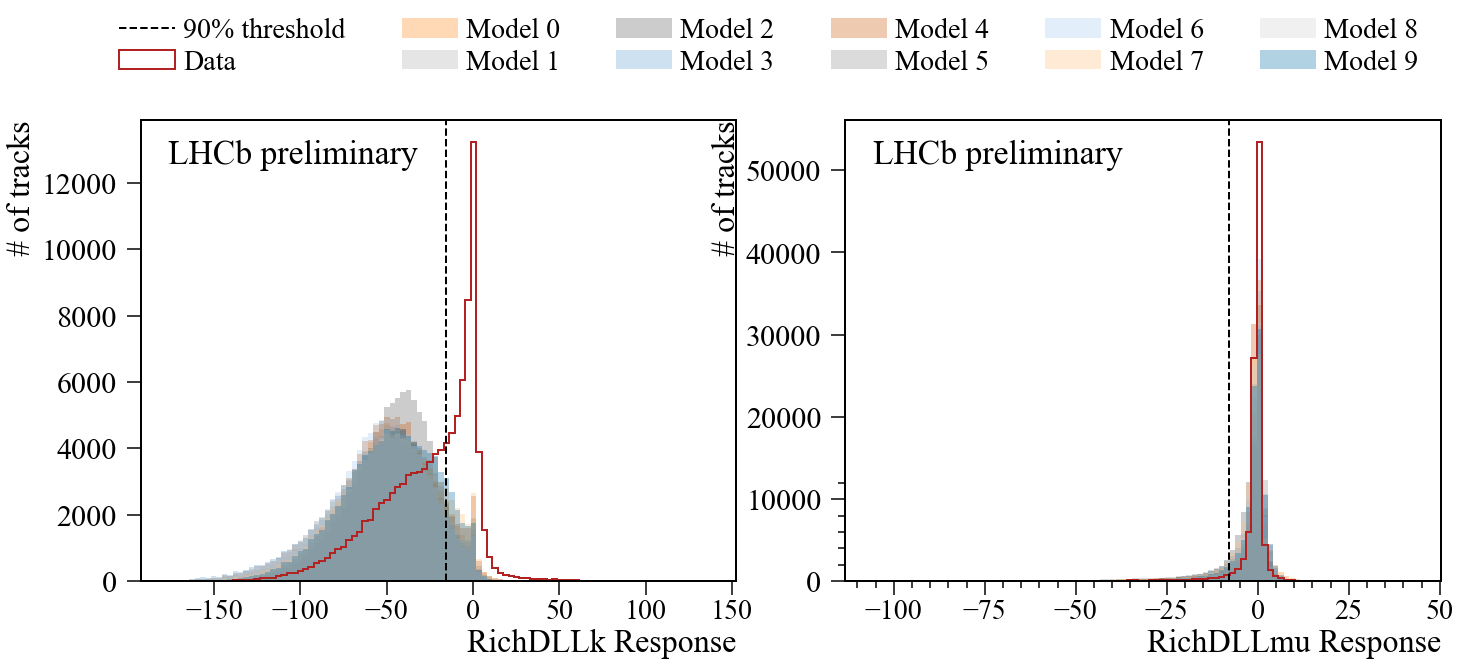

In [283]:
#plt.subplots_adjust(hspace = .3)
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.minorticks_on()
plt.tight_layout()
bins = np.linspace(-100, 50, 500)
for INDEX, ax in zip((1, 2), axes.flatten()[:5]):
    h1, bins, _ = ax.hist(TEST_DATA[f'dlls_n[:, {INDEX}]'],
                      bins=100,
                      label="Data", fill=False, edgecolor='firebrick', histtype='step', linewidth=2)
    x_text = h1.max()
    for i, p in enumerate(range(10)):
        h1, _, _ = ax.hist(TEST_DATA[f'preds_n[:, {INDEX}][{i}'],
                bins=bins,
                label=f"Model {i}",
                alpha=0.3)
        x_text = max(x_text, h1.max())
    _, bins, _ = ax.hist(TEST_DATA[f'dlls_n[:, {INDEX}]'],
                  bins=bins,
                  fill=False, edgecolor='firebrick', histtype='step', linewidth=2)

    ax.axvline(TRAIN_DATA[f'thrs[{INDEX}]'], color='k', linestyle='dashed', linewidth=2, label='90% threshold')
    ax.set_xlabel(f'{dll_columns[INDEX]} Response', ha='right', x=1)
    #ax.ticklabel_format(axis='y', style='sci')

    ax.set_ylabel('# of tracks', ha='right', y=1)
    ax.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000], [0, 2, 4, 6, 8, 10, 12])

    #ax.ticklabel_format(axis='y', style='sci', useOffset=False)
    #labels = [item.get_text() for item in ax.get_yticklabels()]
    #print(labels)
    #    ax.set_title(dll_columns[INDEX])
    ax.text(bins[0], x_text*0.95, "LHCb preliminary", horizontalalignment='left', size='large', color='black')
    #ax.minorticks_on()

handles, labels = ax.get_legend_handles_labels()
#plt.minorticks_on()
#ax.ticklabel_format(axis='y', style='sci')

# Create a legend for the first line.
#first_legend = fig.legend(handles[2:], labels[2:], loc='center right', fancybox=True, shadow=True, ncol=1, borderaxespad=0, bbox_to_anchor=(1.15, 0.5))

# Add the legend manually to the Axes.
#fig.add_artist(first_legend)

# Create another legend for the second line.
#fig.legend(handles=[line2], loc='lower right')
#fig.legend(handles[:2], labels[:2], loc='upper center', fancybox=True, shadow=True, ncol=2, borderaxespad=0)
fig.legend(handles, labels, loc='upper center', ncol=6, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(0.5, 1.15))



#legend.frameon:       false
#legend.handletextpad: 0.3
#legend.numpoints:     1
#legend.labelspacing:  0.2
#legend.fontsize:      28
plt.savefig('test set dlls.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()


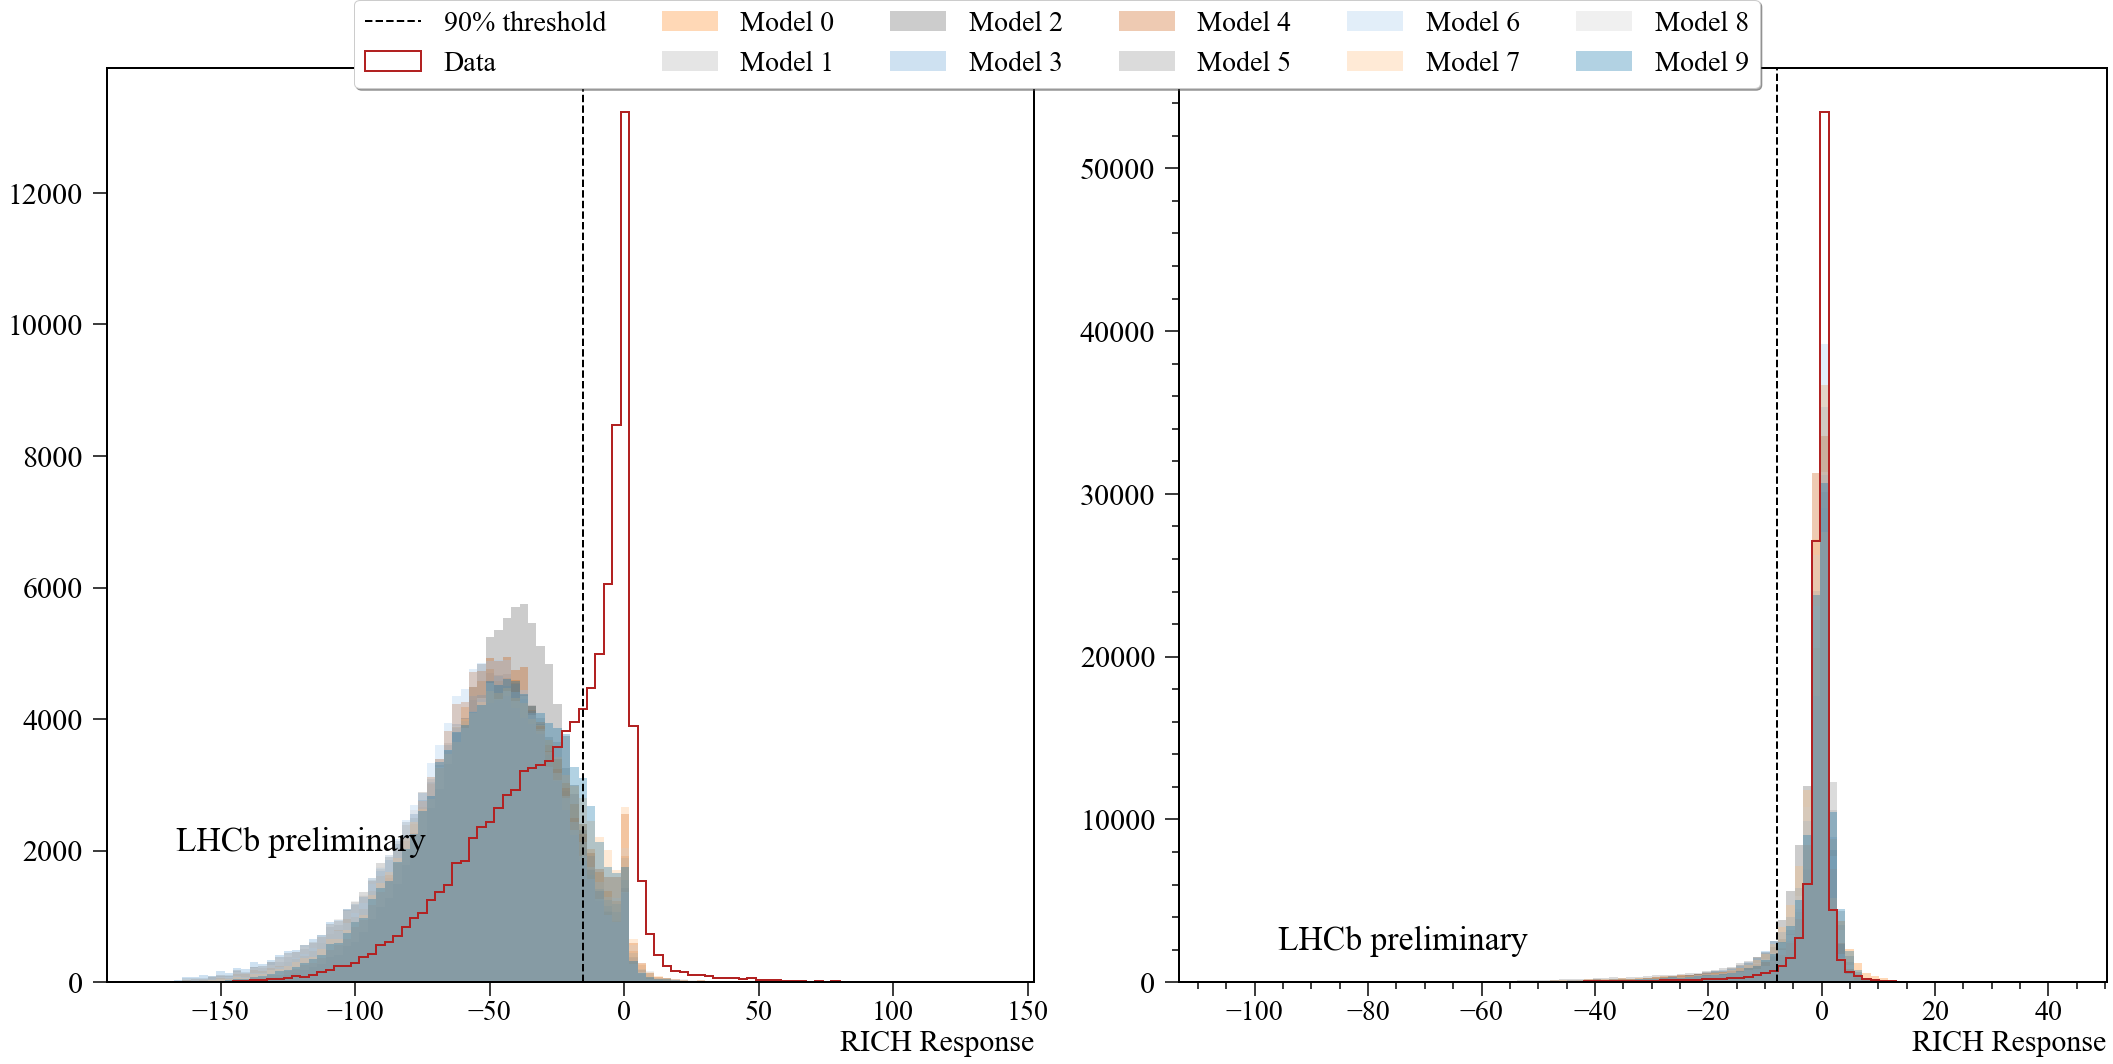

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
plt.subplots_adjust(hspace = .3)
plt.style.use('tableau-colorblind10')

for INDEX, ax in zip((1, 2), axes.flatten()[:5]):
    _, bins, _ = ax.hist(TEST_DATA[f'dlls_n[:, {INDEX}]'],
                      bins=100,
                      label="Data", fill=False, edgecolor='firebrick', histtype='step', linewidth=2)
    for i, p in enumerate(range(10)):
        ax.hist(TEST_DATA[f'preds_n[:, {INDEX}][{i}'],
                bins=bins,
                label=f"Model {i}",
                alpha=0.3)
    _, bins, _ = ax.hist(TEST_DATA[f'dlls_n[:, {INDEX}]'],
                  bins=bins,
                  fill=False, edgecolor='firebrick', histtype='step', linewidth=2)

    ax.axvline(TEST_DATA[f'thrs[{INDEX}]'], color='k', linestyle='dashed', linewidth=2, label='90% threshold')
    ax.text(bins[0] + 10, 2000, "LHCb preliminary", horizontalalignment='left', size='large', color='black')
    ax.set_xlabel('RICH Response', fontsize=30, ha='right', x=1)
    ax.set_title(dll_columns[INDEX])
handles, labels = ax.get_legend_handles_labels()
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)

# Create a legend for the first line.
#first_legend = fig.legend(handles[2:], labels[2:], loc='center right', fancybox=True, shadow=True, ncol=1, borderaxespad=0, bbox_to_anchor=(1.15, 0.5))

# Add the legend manually to the Axes.
#fig.add_artist(first_legend)

# Create another legend for the second line.
#fig.legend(handles=[line2], loc='lower right')
#fig.legend(handles[:2], labels[:2], loc='upper center', fancybox=True, shadow=True, ncol=2, borderaxespad=0)
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=6, borderaxespad=0)
plt.minorticks_on()
plt.tight_layout() 


plt.savefig('train set dlls(1).svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()


In [249]:
def smoothen_values(x, y, num_points=200, spline_power=2):
    from scipy.interpolate import make_interp_spline

    xnew = np.linspace(min(x), max(x), num_points)
    spl = make_interp_spline(x, y, k=spline_power)
    ynew = spl(xnew)

    return xnew, ynew
def log10_inverse(x):
    return np.power(10, x) / 1000

In [50]:
def conditional_gan(x, trues=None, i=None):
    if i is not None:
        model = getattr(netGs, 'Gmodel_' + str(i))
        return model(torch.tensor(x).to(device)).cpu().detach().numpy()
    preds = netGs(torch.tensor(x).to(device))
    if trues is not None:
        assert(preds.shape[1] == len(trues))
  
    return preds.cpu().detach().numpy()


In [144]:
c1 = (89., 89., 89.)
c2 = (255.,128.,14.)
c3= (0.,107.,164.,)
c4=(162.,200.,236.)
c5=(255.,188.,121.)
c6 = (200.,82.,0.)

In [145]:
colors= [c1, c2, c3, c4, c5, c6]
for i in range(6):
    colors[i] = tuple([ci/255 for ci in colors[i]])

In [1]:
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

n_bounds = 40

for idx, ax in zip((1, 2), axes.flatten()):
    threshold = TEST_DATA[f'thrs[{idx}]']
    

    # for i, pred in enumerate(ensemble_preds_val):

    d = random_test[f'particle_{idx}']
    x = d['x']
    eff = d['data_efficiency']
    err = [0] * len(d['data_efficiency'])
    ax.errorbar(log10_inverse(x), eff, err, fmt='*', color=colors[2], linewidth=2)
    ax.plot(log10_inverse(x), eff, label='Data', color=colors[2], linewidth=2)
    efficiency = d['efficiency']
    eff_low = d['eff_low']
    eff_high = d['eff_high']

    feats_val = d['feats_val']
    ax.plot (log10_inverse(x), d['eff_means_ae'], '-',label='Adversarial Ensemble Prediction', linewidth=2, color=colors[1])
    
    x_fill, eff_high_fill = smoothen_values(x, d['eff_highs_ae'])
    x_fill, eff_low_fill = smoothen_values(x, d['eff_lows_ae'])
    ax.fill_between(log10_inverse(x_fill), eff_high_fill, eff_low_fill, alpha=0.2, label='Adversarial Ensemble Uncertainty bound', color=colors[1])

    y_low = min(eff_high) - 0.1

    #ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Momentum, GeV/c", ha='right', x=1)
    ax.set_ylabel("Background rejection", ha='right', y=1)
    ax.set_ylim(y_low, 1.1)
    ax.set_xscale('log')
    if idx == 1:
        ax.text(1.1, 0.1, "LHCb preliminary", horizontalalignment='left', size='large', color='black')
    else:
        ax.text(1.1, 0.125, "LHCb preliminary", horizontalalignment='left', size='large', color='black')

        #ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(0.5, 1.1))

plt.show()
fig.savefig('random_test.svg', format='svg', dpi=1200, bbox_inches='tight')

NameError: name 'plt' is not defined

In [52]:
line_test[f'particle_0'].keys()

dict_keys(['x', 'efficiency', 'eff_low', 'eff_high', 'data_efficiency', 'efficiency_means_ae', 'efficiency_lows_ae', 'efficiency_high_ae'])

In [53]:
line_test[f'particle_3'].keys()

dict_keys(['x', 'efficiency', 'eff_low', 'eff_high', 'data_efficiency'])

In [54]:
TRAIN_DATA.keys()

dict_keys(['weights', 'dlls_n[:, 1]', 'preds_n[:, 1][0]', 'preds_n[:, 1][1]', 'preds_n[:, 1][2]', 'preds_n[:, 1][3]', 'preds_n[:, 1][4]', 'preds_n[:, 1][5]', 'preds_n[:, 1][6]', 'preds_n[:, 1][7]', 'preds_n[:, 1][8]', 'preds_n[:, 1][9]', 'thrs[1]', 'dlls_n[:, 2]', 'preds_n[:, 2][0]', 'preds_n[:, 2][1]', 'preds_n[:, 2][2]', 'preds_n[:, 2][3]', 'preds_n[:, 2][4]', 'preds_n[:, 2][5]', 'preds_n[:, 2][6]', 'preds_n[:, 2][7]', 'preds_n[:, 2][8]', 'preds_n[:, 2][9]', 'thrs[2]'])

10 10
10 10


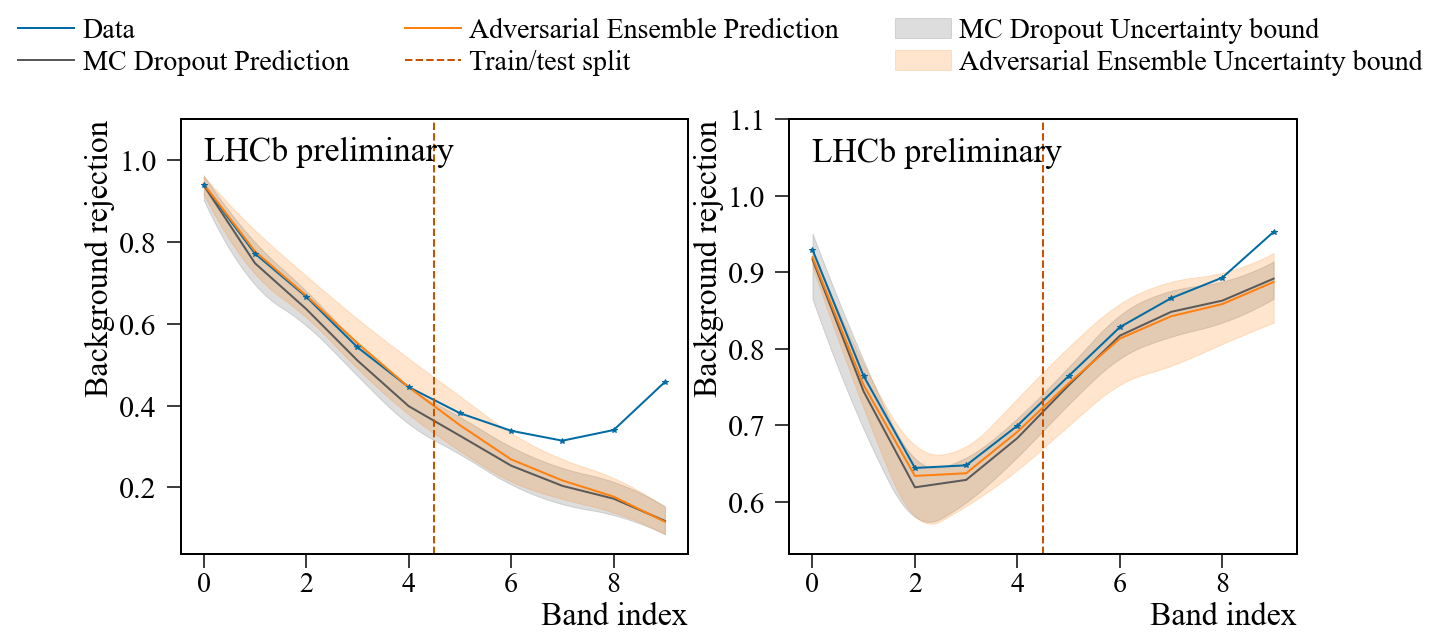

In [253]:
dll_columns = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
num_train_bands = 5
for idx, ax in zip((1, 2), axes.flatten()):
    #threshold = thrs[idx]

    model_plot_handlers = []
    #for i in range(num_models):
    #    eff = effs[f'{idx}_{i}']
    #    err = errs[f'{idx}_{i}']
    #    x = list(range(len(eff)))
    #    x, eff, err = efficiency_bands(pred, threshold, idx)
    #    handler = ax.errorbar(x, eff, err, fmt='.', label=f'Model {i}')
    #    model_plot_handlers.append(handler)

#    x, efficiency, eff_low, eff_high, errors = efficiency_bands_with_uncertainty(band_single_preds, 
#                                                                                 band_feats, 
#                                                                                 ens_unc_model,
#                                                                                 ref_unc_model,
#                                                                                 threshold, 
#                                                                                 idx)

#    x, eff, err = efficiency_bands(band_targets, threshold, idx)


    d = line_test[f'particle_{idx}']
    x = d['x']
    eff = d['data_efficiency']
    err = [0] * len(d['data_efficiency'])
    efficiency = d['efficiency']
    eff_low = d['eff_low']
    eff_high = d['eff_high']

    ax.errorbar(x, eff, err, fmt='*', color=colors[2], linewidth=2)
    ax.plot(x, eff, label='Data', color=colors[2], linewidth=2)
    ax.plot (x, efficiency, '-', label='MC Dropout Prediction', linewidth=2, color=colors[0])
    


    x_fill, eff_high_fill = smoothen_values(x, eff_high)
    x_fill, eff_low_fill = smoothen_values(x, eff_low)
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='MC Dropout Uncertainty bound',color=colors[0])

    efficiency = d['efficiency_means_ae']
    eff_low = d['efficiency_lows_ae']
    eff_high = d['efficiency_high_ae']
    #eff = data_effs[str(idx)]
    #err = data_errs[str(idx)]
    #x = list(range(len(eff)))

    print(len(efficiency), len(eff))

    #noise = [0, 0.01, 0.02, 0.033, 0.0456, 0.034, 0.03, 0.013, 0.01, 0.0]
    #ax.plot (x, np.array(efficiency), '-', color='steelblue', label='MC-Dropout Prediction')
    ax.plot (x, efficiency, '-', label='Adversarial Ensemble Prediction', linewidth=2, color=colors[1])
    x_fill, eff_high_fill = smoothen_values(x, eff_high)
    x_fill, eff_low_fill = smoothen_values(x, eff_low)
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='Adversarial Ensemble Uncertainty bound', color=colors[1])

    #x_fill, eff_high_fill = smoothen_values(x, np.array(eff_high) + np.array(noise))
    #x_fill, eff_low_fill = smoothen_values(x, np.array(eff_low) - np.array(noise))
    #ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='MC-Dropout Uncertainty bound', color='steelblue')
    
    # ax.plot (x_fill, eff_high_fill, '-.', color='blue', alpha=0.3)
    # ax.plot (x_fill, eff_low_fill, '-.', label='Uncertainty bound', color='blue', alpha=0.3)

    y_low = min(eff_high) - 0.05

    ax.axvline(num_train_bands - 0.5, color=colors[5], linestyle='--', linewidth=2, 
               label='Train/test split')

    #ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Band index", ha='right', x=1)
    ax.set_ylabel("Background rejection", ha='right', y=1)
    ax.set_ylim(y_low, 1.1)
    if idx == 1:
        ax.text(0, 1, "LHCb preliminary", horizontalalignment='left', size='large', color='black')
    else:
        ax.text(0, 1.045, "LHCb preliminary", horizontalalignment='left', size='large', color='black')


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(0.5, 1.1))

plt.show()
fig.savefig('extrapolation_test.svg', format='svg', dpi=1200, bbox_inches='tight')


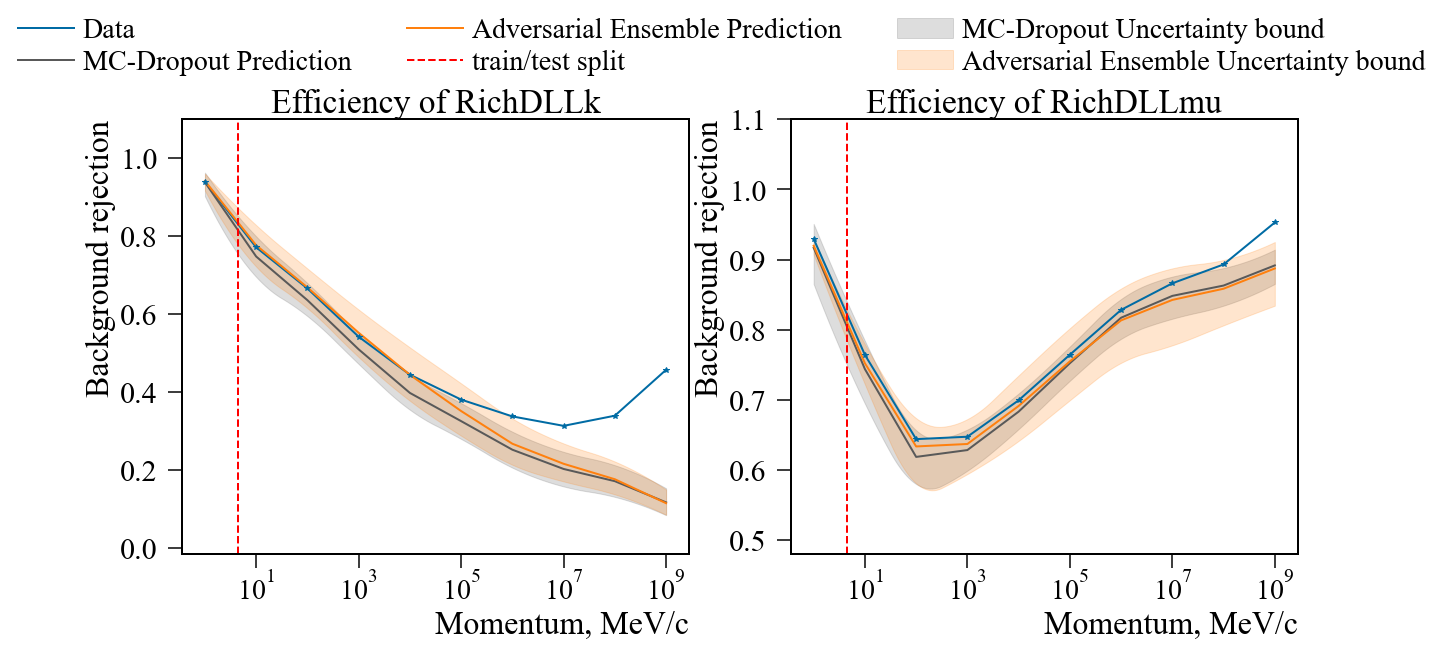

In [151]:
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(hspace = .5)

n_bounds = 40

for idx, ax in zip((1, 2), axes.flatten()):
    threshold = TEST_DATA[f'thrs[{idx}]']
    

    # for i, pred in enumerate(ensemble_preds_val):

    d = line_test[f'particle_{idx}']
    x = d['x']
    eff = d['data_efficiency']
    err = [0] * len(d['data_efficiency'])
    ax.errorbar(log10_inverse(x), eff, err, fmt='*', color=colors[2])
    ax.plot(log10_inverse(x), eff, label='Data', color=colors[2], linewidth=2)
    efficiency = d['efficiency']
    eff_low = d['eff_low']
    eff_high = d['eff_high']

    #feats_val = d['feats_val']
    ax.plot (log10_inverse(x), efficiency, '-', label='MC-Dropout Prediction', linewidth=2, color=colors[0])
    #mcdropout_results[f'particle_{idx}']['eff_means_ae'] = eff_means[f'{idx}']
    #mcdropout_results[f'particle_{idx}']['eff_lows_ae'] = eff_lows[f'{idx}']
    #mcdropout_results[f'particle_{idx}']['eff_highs_ae'] = eff_highs[f'{idx}']

    ax.plot (log10_inverse(x), d['efficiency_means_ae'], '-',label='Adversarial Ensemble Prediction', linewidth=2, color=colors[1])
    
    x_fill, eff_high_fill = smoothen_values(x, eff_high)
    x_fill, eff_low_fill = smoothen_values(x, eff_low)
    ax.fill_between(log10_inverse(x_fill), eff_high_fill, eff_low_fill, alpha=0.2, label='MC-Dropout Uncertainty bound', color=colors[0])

    x_fill, eff_high_fill = smoothen_values(x, d['efficiency_high_ae'])
    x_fill, eff_low_fill = smoothen_values(x, d['efficiency_lows_ae'])
    ax.fill_between(log10_inverse(x_fill), eff_high_fill, eff_low_fill, alpha=0.2, label='Adversarial Ensemble Uncertainty bound', color=colors[1])

    y_low = min(eff_high) - 0.1

    ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Momentum, MeV/c", ha='right', x=1)
    ax.set_ylabel("Background rejection", ha='right', y=1)
    ax.set_ylim(y_low, 1.1)
    ax.set_xscale('log')
    ax.axvline(5 - 0.5, color='red', linestyle='--', linewidth=2, label='train/test split')
    #ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(0.5, 1.1))

font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.show()
fig.savefig('random_test.svg', format='svg', dpi=1200)